<a href="https://colab.research.google.com/github/derrickgzq/yenheranalysis/blob/main/Yenher_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required libraries

In [1]:
install.packages('fpp3')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘warp’, ‘BH’, ‘Rcpp’, ‘distributional’, ‘progressr’, ‘slider’, ‘anytime’, ‘fable’, ‘fabletools’, ‘feasts’, ‘tsibble’, ‘tsibbledata’




In [17]:
install.packages('urca')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Calling libraries

In [5]:
library(fpp3)
library(readr)

Fetching dataset

In [6]:
url = 'https://raw.githubusercontent.com/derrickgzq/yenheranalysis/main/yenher%20pl%20statement.csv'
yenher = read_csv(url)

Rows: 7 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Date
dbl (2): Sales, NetProfit

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
yenher

Date,Sales,NetProfit
<chr>,<dbl>,<dbl>
3/31/2021,58786254,4937613
6/30/2021,67191499,5993644
9/30/2021,66236962,4282637
12/31/2021,71194928,5623225
3/31/2022,76088347,4912869
6/30/2022,102246197,6134572
9/30/2022,98200321,5469771


Convert it to tsibble object

In [9]:
yenherdata = yenher %>% mutate(Date = yearmonth(Date)) %>% as_tsibble(index = Date)
yenherdata

Date,Sales,NetProfit
<mth>,<dbl>,<dbl>
2021 Mar,58786254,4937613
2021 Jun,67191499,5993644
2021 Sep,66236962,4282637
2021 Dec,71194928,5623225
2022 Mar,76088347,4912869
2022 Jun,102246197,6134572
2022 Sep,98200321,5469771


A brief visualization on its Sales and Net Profit

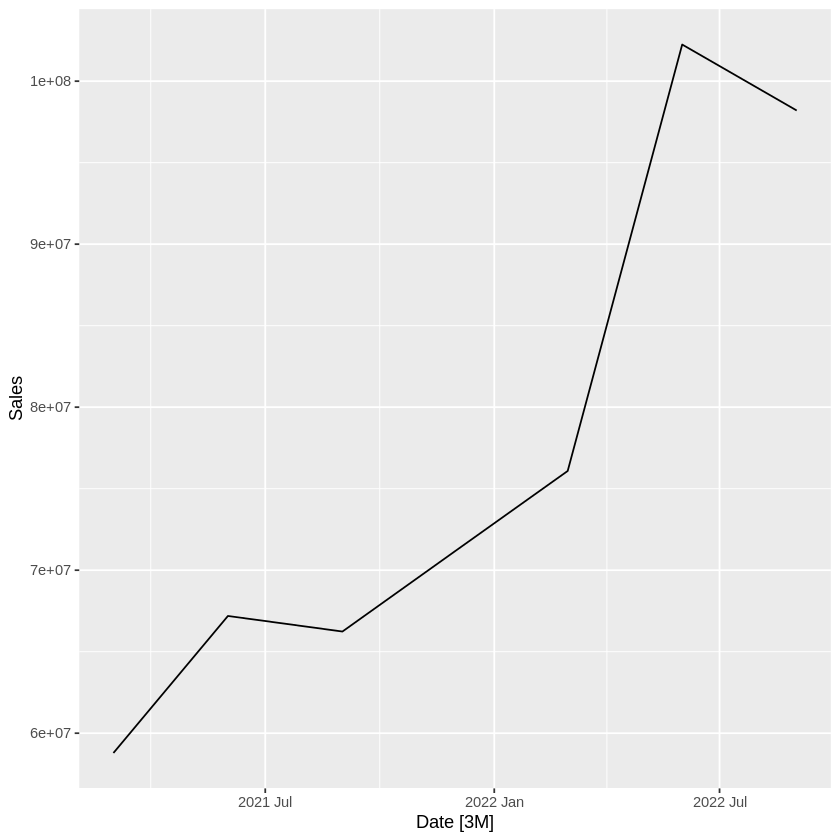

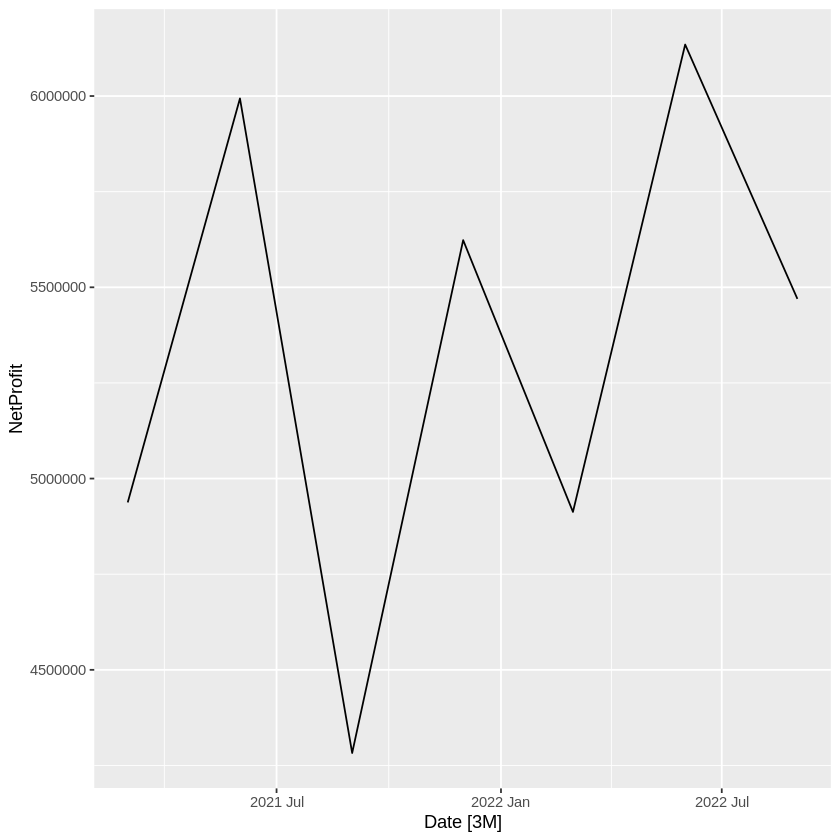

In [14]:
par(mfrow = c(1,2))
autoplot(yenherdata, Sales)
autoplot(yenherdata, NetProfit)

Modelling with all possible model techniques

In [18]:
models = yenherdata %>% model(
    usual = TSLM(Sales ~ trend() + season(period = 4)),
    log = TSLM(log(Sales) ~ trend() + season(period = 4)),
    sqrt = TSLM(sqrt(Sales) ~ trend() + season(period = 4)),
    quartic = TSLM(Sales^(1/4) ~ trend() + season(period = 4)),
    trigo = TSLM(log(Sales) ~ trend() + fourier(period = 4, K = 2)),
    box = ARIMA(Sales, stepwise = FALSE, approximation = FALSE)
)

In [19]:
report(models)

Warning message in report.mdl_df(models):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>
usual,0.9459801,0.8379404,4.497201e+13,8.755851,0.10512162,5,-115.577614,223.290089,Inf,222.965550,Inf,8.994401e+13,2,5,NULL,NULL
log,0.9707136,0.9121407,3.776002e-03,16.572744,0.05771520,5,13.978914,-35.822967,Inf,-36.147506,Inf,7.552004e-03,2,5,NULL,NULL
sqrt,0.9588798,0.8766393,1.058539e+05,11.659465,0.08054959,5,-46.042252,84.219365,Inf,83.894826,Inf,2.117078e+05,2,5,NULL,NULL
quartic,0.9649565,0.8948696,2.519670e+00,13.767998,0.06885887,5,-8.782347,9.699555,Inf,9.375016,Inf,5.039340e+00,2,5,NULL,NULL
trigo,0.9707136,0.9121407,3.776002e-03,16.572744,0.05771520,5,13.978914,-35.822967,Inf,-36.147506,Inf,7.552004e-03,2,5,NULL,NULL
box,NA,NA,2.775028e+14,NA,NA,NA,-125.792025,255.584050,258.584,255.475870,NA,NA,NA,NA,,


Based on the summary, log and trigo has the highest r2, r2 adj, lowest AIC, AICc and BIC. They are the best models.

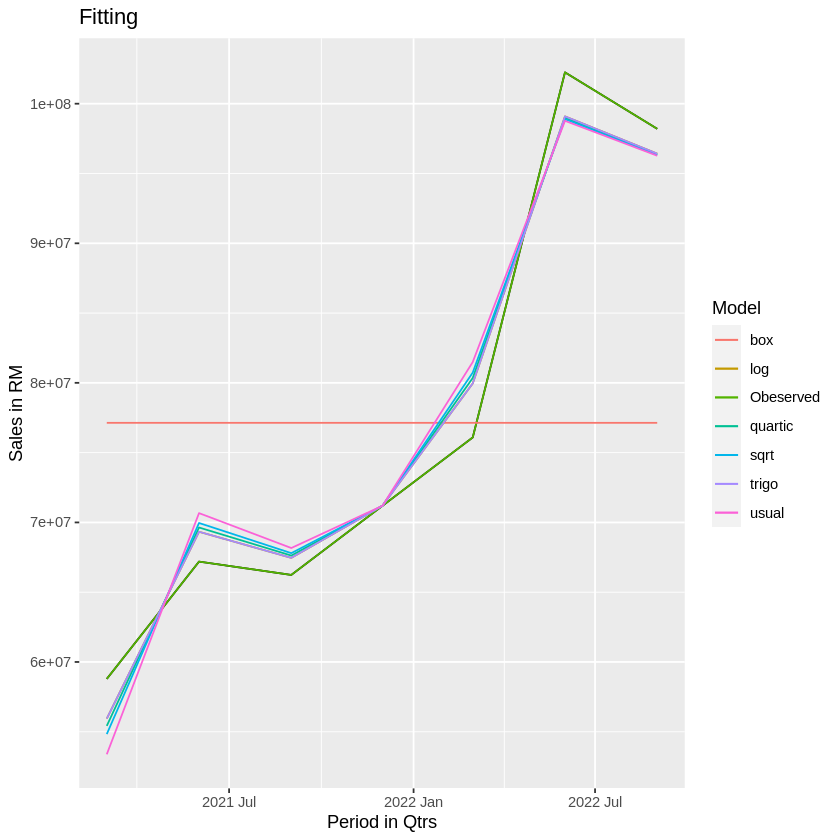

In [23]:
yenherdata %>%
  autoplot(Sales) +
  geom_line(aes(y = Sales, colour = 'Obeserved')) +
  geom_line(aes(y = .fitted, colour = .model), data = fitted(models)) +
  #autolayer(fc_trends, alpha = 0.5, level = 95) +
  xlab('Period in Qtrs') +
  ylab('Sales in RM') +
  ggtitle('Fitting') +
  guides(colour = guide_legend(title = 'Model'))

Residual plots of the best model (Model diagnostic)

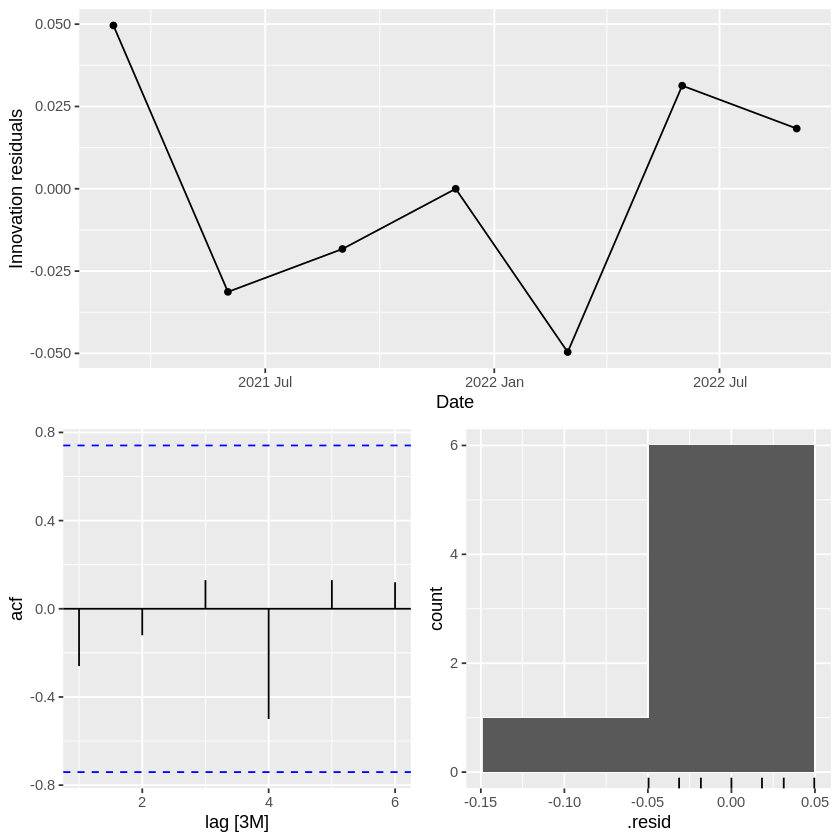

In [24]:
select(models, log) %>% gg_tsresiduals

No spike at acf, within the blue interval signifies residuals do not correlate with each other.

Forecasting

.model,Date,Sales,.mean
<chr>,<mth>,<dist>,<dbl>
log,2022 Dec,"t(N(18, 0.01))",102272608
log,2023 Mar,"t(N(19, 0.011))",114932730
log,2023 Jun,"t(N(19, 0.011))",142438536
log,2023 Sep,"t(N(19, 0.011))",138596866
log,2023 Dec,"t(N(19, 0.018))",146729416
log,2024 Mar,"t(N(19, 0.021))",165097975
log,2024 Jun,"t(N(19, 0.021))",204609373
log,2024 Sep,"t(N(19, 0.021))",199090911


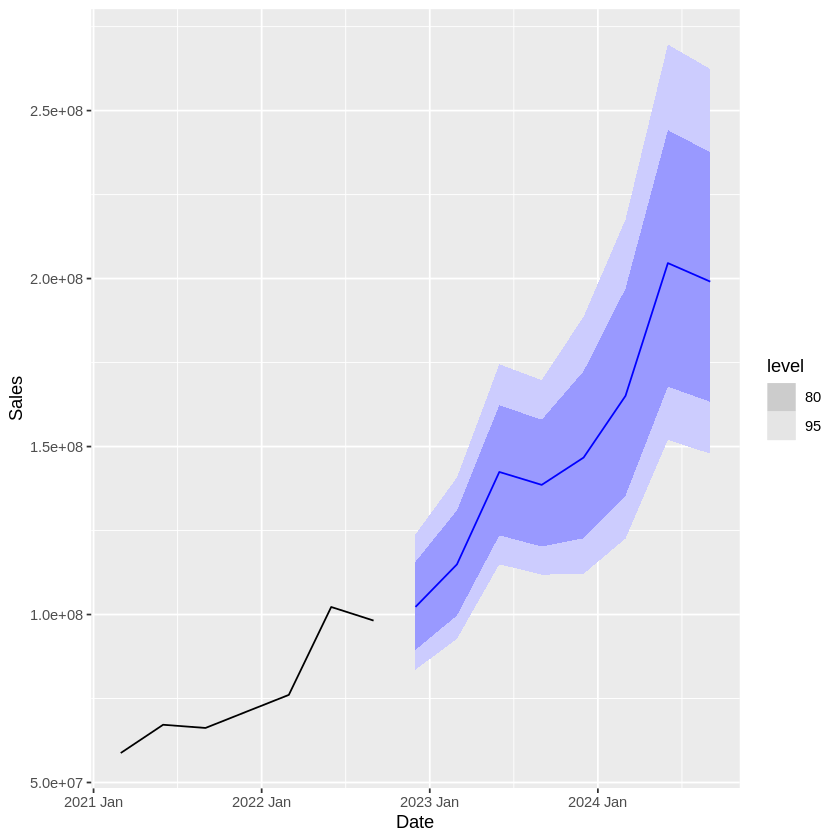

In [27]:
select(models, log) %>% forecast(h = 8) %>% autoplot(yenherdata)
select(models, log) %>% forecast(h = 8) 